# Step 1: Importing the required libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD

# Step 2: Loading the data



In [2]:
#Loading the CIFAR10 data
(X, y), (_, _) = keras.datasets.cifar10.load_data()

#Selecting a single class images
#The number was randomly chosen and any number
#between 1 to 10 can be chosen
X = X[y.flatten() == 8]

# Step 3: Defining parameters to be used in later processes


In [3]:
#Defining the Input shape
image_shape = (32, 32, 3)
latent_dimensions = 100

# Step 4: Defining a utility function to build the Generator

In [4]:
def build_generator():

        model = Sequential()

        #Building the input layer
        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dimensions))
        model.add(Reshape((8, 8, 128)))
        
        model.add(UpSampling2D())
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.78))
        model.add(Activation("relu"))

        model.add(UpSampling2D())

        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.78))
        model.add(Activation("relu"))

        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        #Generating the output image
        noise = Input(shape=(latent_dimensions,))
        image = model(noise)

        return Model(noise, image)

# Step 5: Defining a utility function to build the Discriminator

In [5]:
def build_discriminator():

        #Building the convolutional layers
        #to classify whether an image is real or fake
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.82))
        model.add(LeakyReLU(alpha=0.25))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.82))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.25))
        model.add(Dropout(0.25))

        #Building the output layer
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        image = Input(shape=image_shape)
        validity = model(image)

        return Model(image, validity)

# Step 6: Defining a utility function to display the generated images

In [6]:
def display_images():
        r, c = 4,4
        noise = np.random.normal(0, 1, (r * c,latent_dimensions))
        generated_images = generator.predict(noise)

        #Scaling the generated images
        generated_images = 0.5 * generated_images + 0.5

        fig, axs = plt.subplots(r, c)
        count = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(generated_images[count, :,:,])
                axs[i,j].axis('off')
                count += 1
        plt.show()
        plt.close()

# Step 7: Building the Generative Adversarial Network

In [7]:
# Building and compiling the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5), metrics=['accuracy'])

#Making the Discriminator untrainable
#so that the generator can learn from fixed gradient
discriminator.trainable = False

# Building the generator
generator = build_generator()

#Defining the input for the generator
#and generating the images
z = Input(shape=(latent_dimensions,))
image = generator(z)


#Checking the validity of the generated image
valid = discriminator(image)

#Defining the combined model of the Generator and the Discriminator
combined_network = Model(z, valid)
combined_network.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

# Step 8: Training the network

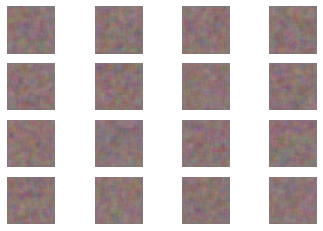

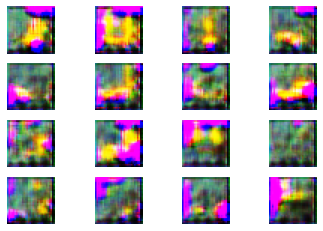

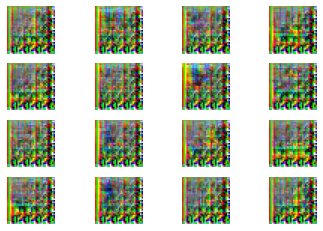

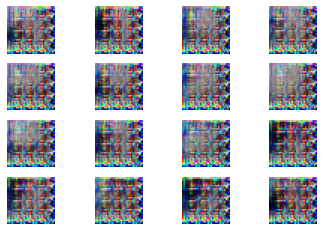

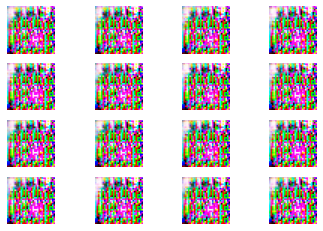

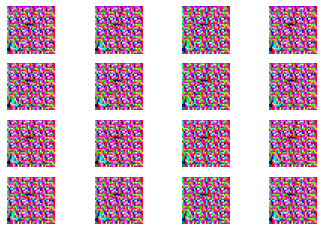

In [8]:
num_epochs=15000
batch_size=32
display_interval=2500
losses=[]

#Normalizing the input
X = (X / 127.5) - 1.

#Defining the Adversarial ground truths
valid = np.ones((batch_size, 1))

#Adding some noise
valid += 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)

for epoch in range(num_epochs):

            #Training the Discriminator

            #Sampling a random half of images
            index = np.random.randint(0, X.shape[0], batch_size)
            images = X[index]

            #Sampling noise and generating a batch of new images
            noise = np.random.normal(0, 1, (batch_size, latent_dimensions))
            generated_images = generator.predict(noise)


            #Training the discriminator to detect more accurately
            #whether a generated image is real or fake
            discm_loss_real = discriminator.train_on_batch(images, valid)
            discm_loss_fake = discriminator.train_on_batch(generated_images, fake)
            discm_loss = 0.5 * np.add(discm_loss_real, discm_loss_fake)

            #Training the Generator

            #Training the generator to generate images
            #which pass the authenticity test
            genr_loss = combined_network.train_on_batch(noise, valid)

            #Tracking the progress
            if epoch % display_interval == 0:
                display_images()

# Plotting the original images

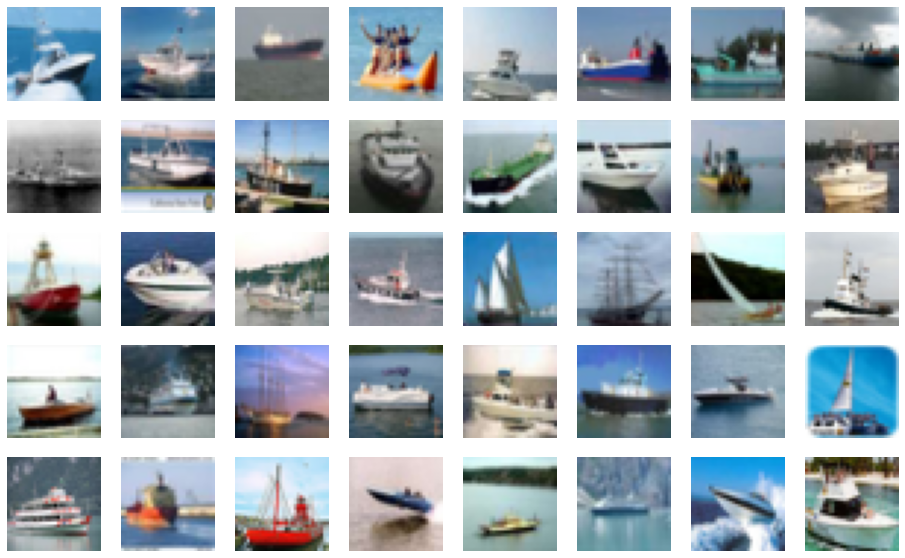

In [9]:
#Plotting some of the original images
s=X[:40]
s = 0.5 * s + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, image in enumerate(s):
    ax[i//8, i%8].imshow(image)
    ax[i//8, i%8].axis('off')

plt.show()

# Plotting the images generated on the last epoch

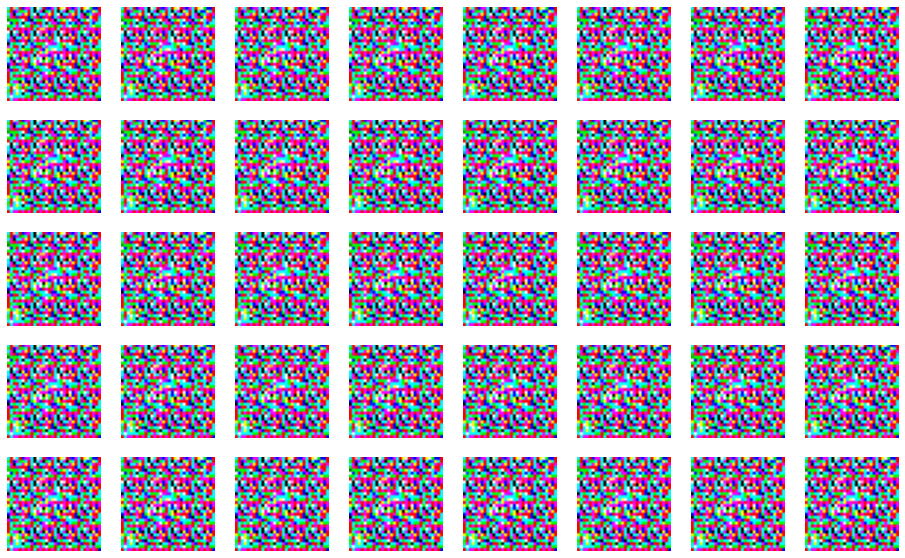

In [10]:
#Plotting some of the last batch of generated images
noise = np.random.normal(size=(40, latent_dimensions))
generated_images = generator.predict(noise)
generated_images = 0.5 * generated_images + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, image in enumerate(generated_images):
    ax[i//8, i%8].imshow(image)
    ax[i//8, i%8].axis('off')

plt.show()